# Reinforcement predictions

## Initialise code

First, we need to load some packages and functions.

In [1]:
# load packages and functions
import numpy as np
import matplotlib.pyplot as plt
from pyrootmemo.io import read_csv_roots
from pyrootmemo.fit import Powerlaw
from pyrootmemo.materials import Soil, Interface
from pyrootmemo.geometry import SoilProfile, FailureSurface
from pyrootmemo.models import Wwm, Fbm, Rbmw, Waldron
# define parameter object (value + unit), used later to define soil, root and geometry parameters
from pyrootmemo.tools.helpers import units  # load the unit system used
from collections import namedtuple
Parameter = namedtuple("parameter", "value unit")

## Load data

There are two files to load, one for biomechanical testing results, and describing the diameters of all roots in the experiment used to measure reinforcement. 

By default, this script uses data a direct shear experiments by Bull et al. (2022) on willow roots, see https://doi.org/10.1098/rspa.2021.0210. Biomechanics data is from Liang et al. (2017), see https://doi.org/10.1016/j.ecoleng.2017.06.067.

Alternatively, you can read in your own data by placing a comma seperated .csv files in the project folder and adjusting the paths below. The 

* The .csv file with 'field' data should contain columns for:
  * `diameter_unit`: the diameter of the roots
* The .csv file describing biomechanical data should contain columns for:
  * `diameter_unit`: the diameters of the tested roots
  * `tensile_strenght_unit`: the tensile strengths of the tested roots
  * `elastic_modulus_unit`: the (elastic) stiffness of the tested roots

The part of the column name indicated by 'unit' must be replaced by the measurement unit, e.g. 'mm'.

In [2]:
# load root diameter data as measured in Bull et al.'s experiment
roots_experiment = read_csv_roots('data/experiment_willowC_bull.csv')
# measure biomechanical data as tested by Liang et al.
roots_biomech = read_csv_roots('data/tensile_willow_liang2017.csv') 

# Biomechanics 

First, we need to fit the biomechanical data, so we can predict root biomechanical properties for all roots in the *experiment*.

In [3]:
# create a power law for tensile strength
fit_tensile_strength = Powerlaw(
    roots_biomech.diameter,
    roots_biomech.tensile_strength,
    model = 'normal'
)
# create a power law for root stiffness
fit_elastic_modulus = Powerlaw(
    roots_biomech.diameter,
    roots_biomech.elastic_modulus,
    model = 'normal'
)

\\myfiles.campus.bath.ac.uk\gjm36\dos\Projects\2023_root_reinforcement_book_Anil_Yildiz\pyrootmemo\src\pyrootmemo\fit.py:105: UserWarning: unit of x0 not defined - assumed millimeter
  warnings.warn(f'unit of x0 not defined - assumed {x.units}')


With these fits, we can now predict the strength and stiffness of any root in the experiment

In [4]:
# predict tensile strenghts
roots_experiment.tensile_strength = fit_tensile_strength.predict(roots_experiment.diameter)
# predict stiffnesses
roots_experiment.elastic_modulus = fit_elastic_modulus.predict(roots_experiment.diameter)

For some models (Waldron, RBMw), we also need to know the (anchored) length of the root. 

Bull et al.'s expriments were sheared half-way a 500 mm long core. Therefore, let's assume that the (anchored) length, i.e. the distance from the shear plane to the tip of all roots, is 250 mm for all roots.

In [5]:
# diameter--length power law parameters
length_multiplier = 250 * units('mm')
length_exponent = 0.0
reference_diameter = 1.0 * units('mm')
# set length for each root, using power law
roots_experiment.length = length_multiplier * (roots_experiment.diameter / reference_diameter) ** length_exponent

# Set soil and interface properties

Let's define come soil properties. You can define multiple soils, but In Bull's experiment, there is only one soil.

In [6]:
soil = Soil(
    'silty SAND',
    cohesion = Parameter(0.0, 'kPa'),
    friction_angle = Parameter(36.4, 'degrees')
)

With the soil(s) defined, we can now define a soil profile. This is a list of soils - stacked on top of each other (top to bottom). For each soil in the 'stack' define the bottom of the layer.

Bull's tests were conducted in a 500 mm long core, so the depth of the silty sand is at 500 mm below the soil surface

In [7]:
soil_profile = SoilProfile(
    [soil],
    depth = Parameter([500.0], 'mm')
)

The Waldron model requires defining the strength of the root-soil interface.

In [8]:
interface = Interface(
    shear_strength = Parameter(2.7, 'kPa')
)

Finally, let's set some parameters for the failure surface. In Bull's test, these were located at 250 mm depth. The cores were 110 mm in diameter.

In [9]:
failure_surface = FailureSurface(
    cross_sectional_area = Parameter(0.25 * np.pi * 110**2, 'mm^2'),
    depth = Parameter(250, 'mm'),
    shear_zone_thickness = Parameter(30, 'mm')
)

## Reinforcement predictions

With all properties defined, we can now start to make reinforcement predictions using the various models.

### WWM

In [10]:
# create a Wwm model object
wwm = Wwm(roots_experiment)
# calculate and show the peak reinforcement (in kPa)
peak_reinforcement = wwm.peak_reinforcement(failure_surface)
print(peak_reinforcement.to('kPa'))

46.05743208174034 kilopascal


### FBM

16.834854432658805 kilopascal


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Force in reference root [N]', ylabel='Total force in root bundle [N]'>)

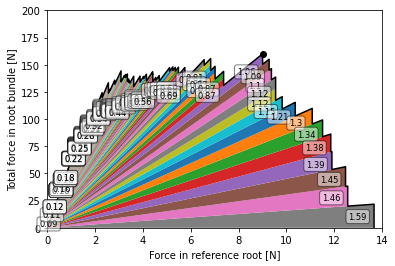

In [11]:
# define the load sharing parameter
load_sharing = 1.0
# create a Fbm model object
fbm = Fbm(roots_experiment, load_sharing)
# calculate and show the peak reinforcement (in kPa)
peak_reinforcement = fbm.peak_reinforcement(failure_surface)
print(peak_reinforcement.to('kPa'))
# show a plot demonstrating how the reinforcement mobilises
# if `stack = True`, show all contributions of individual roots (can be labelled, e.g. by diameter)
fbm.plot(
    stack = True, 
    labels = [str(round(d, 2)) for d in roots_experiment.diameter.magnitude]
    )

### RBMw

In [ ]:
# define the Weibull shape parameter
weibull_shape = 4.0
# create a Rbmw model object
rbmw = Rbmw(roots_experiment, weibull_shape)
# # calculate and show the peak reinforcement (in kPa)
peak = rbmw.peak_reinforcement(failure_surface)
print(peak['reinforcement'].to('kPa'))
# # show a plot demonstrating how the force in the bundle mobilises with displacement
# # if `stack = True`, show all contributions of individual roots (can be labelled, e.g. by diameter)
# rbmw.plot(
#     stack = True,
#     labels = [str(round(d, 2)) for d in roots_experiment.diameter.magnitude]
#     )

{'force': <Quantity(200.256818, 'megapascal * millimeter ** 2')>, 'displacement': <Quantity(38.132192, 'millimeter')>}


### Waldron

In [13]:
# create a Waldron model object. We can include the effects of breakage and/or 
# slippage by setting model parameters to `True` or `False`
waldron = Waldron(
    roots_experiment,
    interface,
    soil_profile,
    failure_surface,
    breakage = True,
    slipping = True    
    )
# calculate and show the peak reinforcement (in kPa)
peak_reinforcement = waldron.peak_reinforcement()[1]
print(peak_reinforcement.to('kPa'))
# show how the reinforcement mobilises with soil shear displacement
# if `stack = True`, show all contributions of individual roots (can be labelled, e.g. by diameter)
waldron.plot(
    stack = True,
    labels = [str(round(d, 2)) for d in roots_experiment.diameter.magnitude]
    )

NameError: name 'isintance' is not defined

## Explore!

You can now investigate:
* How do the different reinforcement models compare?
  * Peak reinforcement
  * Displacements required to reach peak (Waldron, Rbmw)
  * Which roots are predicted to break first - thicker or thinner ones?
* What happens if you make different assumptions, for example for:
  1. Power law fitting methods for root tensile strength and/or root stiffness
  2. FBM load sharing paramter
  3. RBMw Weibull shape parameter
  4. Different soil properties (friction angle)
  5. Different soil-root interface properties (in Waldron model). When do roots slip? When to roots break? Is accounting for slippage important?
  6. Different failure surface properties (e.g. shear zone thickness in Waldron's model?)